# APPM X720 Biweekly Report

### *Alexey Yermakov*
### *February 15 2022*

# Summary

In this report, I focus on [GloVe](https://github.com/stanfordnlp/GloVe) by studying the trained vectors in 50 and 300 dimensions. In doing so, I find interesting words in the 400,000 most frequent words trained by GloVe, I study the cosine similarity distances and perform similar operations presented in [word2vec](https://arxiv.org/pdf/1301.3781.pdf), and I gain intuition about how t-SNE works by studying some plots I generated on 300 dimensional GloVe vectors.

# Main Content

### **GloVe Vector Analysis**

For this report I wanted to explore GloVe. I first re-read the [paper](https://nlp.stanford.edu/pubs/glove.pdf).

Reading the paper, I learned that one of the main goals of the GloVe (which stands for Global Vectors) model is to take into account the "global corpus statistics" instead of what "window-based" methods provide. The paper implies that the latter gives a shallow view of the total statistics of word relationships. The former, however, gives a much more broad sense of which terms appear near one another by providing a value for any pair of two words. Thus, GloVe utilizes the co-occurrence matrix which has a non-negative integer for each pair of words in a corpus.

Lets now dive into the results for [GloVe](https://github.com/stanfordnlp/GloVe). One of the things that caught my attention was the "pre-trained" word vectors. Lets analyze what properties these word-vectors have. First, I have my standard imports.

In [1]:
# Make sure PyTorch is installed and our GPU is available
import torch
import numpy as np
from torch import nn, permute, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import urllib
from PIL import Image
import time
import os
import re
from sklearn.manifold import TSNE

print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


I then downloaded the word-vector representations that came out of GloVe by training on the [Wikipedia 2014 + Gigaword 5](https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip) database. Below is a helper function to parse the files and extract them to what I need.

In [2]:
# Returns a list of vectors and a list of words from the file, as well as the dimension of the vectors
def get_vecs(file_name):
    # Initialize return variables
    vec_list = list()
    words_list = list()
    vec_dim = 0
    # Open file
    with open(file_name) as f:
        # Read line by line
        for line in f.readlines():
            # Split by white space
            line = line.split()
            # Add word to words list
            words_list.append(line[0])
            # Convert vector represenation from strings to floats
            vec = list(map(lambda x: float(x), line[1:]))
            # Add vector representation to return list
            vec_list.append(vec)
        return words_list, vec_list, len(vec_list[0])
    raise Exception("get_vecs: File cound not be opened")

words, vecs, vec_dim = get_vecs('/home/alexey/School/APPM 4720/Biweekly/Feb15/Report/word_vecs/glove.6B.50d.txt')

According to the paper, we should see that the `words` array should contain 400,000 words, consisting of the 400,000 most frequent words from the dataset.

In [3]:
print("Number of words: ", len(words))
print("Number of vectors:", len(vecs))
print("Vector dimensions:", vec_dim)

Number of words:  400001
Number of vectors: 400001
Vector dimensions: 50


Looks like we're one over?

In [4]:
print(words[-1])
print(vecs[-1])

<unk>
[0.072617, -0.51393, 0.4728, -0.52202, -0.35534, 0.34629, 0.23211, 0.23096, 0.26694, 0.41028, 0.28031, 0.14107, -0.30212, -0.21095, -0.10875, -0.33659, -0.46313, -0.40999, 0.32764, 0.47401, -0.43449, 0.19959, -0.55808, -0.34077, 0.078477, 0.62823, 0.17161, -0.34454, -0.2066, 0.1323, -1.8076, -0.38851, 0.37654, -0.50422, -0.012446, 0.046182, 0.70028, -0.010573, -0.83629, -0.24698, 0.6888, -0.17986, -0.066569, -0.48044, -0.55946, -0.27594, 0.056072, -0.18907, -0.59021, 0.55559]


Scrolling down to the file I parsed, it's clear that there are 400,001 lines, which is what we see, though I'm not sure what `<unk>` is. Maybe it means `unknown`? Or maybe it's a grouping of all of the remaining words that didn't make the top 400,000. In either case, I'll just ignore this "word".

In [5]:
words = words[:-1]
vecs = vecs[:-1]

print("Number of words: ", len(words))
print("Number of vectors:", len(vecs))
print("Vector dimensions:", vec_dim)

Number of words:  400000
Number of vectors: 400000
Vector dimensions: 50


Lets now print the top 10 and bottom 10 most frequent words. Note that no where does it say the input file is in terms of frequency, but as we can see below it can be implied.

In [6]:
# Prints first and last n words of the words vector
def print_top_bottom_n(n, words):
    for i in range(n):
        print(f"#{i+1:<7}:{words[i]}")
    print("       ...")
    for i in range(len(words)-n,len(words)):
        print(f"#{i+1:<7}:{words[i]}")

print_top_bottom_n(10, words)

#1      :the
#2      :,
#3      :.
#4      :of
#5      :to
#6      :and
#7      :in
#8      :a
#9      :"
#10     :'s
       ...
#399991 :sigarms
#399992 :katuna
#399993 :aqm
#399994 :1.3775
#399995 :corythosaurus
#399996 :chanty
#399997 :kronik
#399998 :rolonda
#399999 :zsombor
#400000 :sandberger


Some immediate observations:
1) It seems almost certainly that the list is in terms of frequency, since "the" is first, along with "a", "of", and "and" in the top 10.
2) Special characters like "," and "." aren't exactly words but are included in this list.
3) Numbers appear as well, such as "1.3775".

So, lets dig deeper and count up the number of words that contain just numbers (including decimals), just letters, and both. Below I define some helper functions using [regex](https://docs.python.org/3/howto/regex.html) to find fun words included in the list.

In [7]:
# Define helper functions
def is_alpha(word):
    p = re.compile('^[a-zA-Z-_]+$')
    return p.match(word) is not None

def is_num(word):
    p = re.compile('^[0-9.,/]+$')
    return p.match(word) is not None

def is_alpha_num(word):
    p = re.compile('^[a-zA-Z0-9.,-/_]+$')
    return p.match(word) is not None

# Run some basic tests
for func, name in [(is_alpha, "Alphabetical"), (is_num, "Numeric"), (is_alpha_num, "Alphanumeric")]:
    print(f"Checking for {name}")
    for test_word in ["Test", "Test1", "123", "1.23", "\"", "<bruh>", "<1bro>", "<123>", "big-sleep", "1,200", "1/2", "day_care"]:
        print(f"{test_word:<12}:", func(test_word))
    print("")

Checking for Alphabetical
Test        : True
Test1       : False
123         : False
1.23        : False
"           : False
<bruh>      : False
<1bro>      : False
<123>       : False
big-sleep   : True
1,200       : False
1/2         : False
day_care    : True

Checking for Numeric
Test        : False
Test1       : False
123         : True
1.23        : True
"           : False
<bruh>      : False
<1bro>      : False
<123>       : False
big-sleep   : False
1,200       : True
1/2         : True
day_care    : False

Checking for Alphanumeric
Test        : True
Test1       : True
123         : True
1.23        : True
"           : False
<bruh>      : False
<1bro>      : False
<123>       : False
big-sleep   : True
1,200       : True
1/2         : True
day_care    : True



Now lets loop through our list of words and print anything that stands out.

In [8]:
# Define counters

def find_cool_words(words):
    # Counters
    alpha = 0
    num = 0
    alpha_num = 0
    # Store cool words
    cool_words = list()
    for word in words:
        hit = 0 # Flag to see if the word fit in any category
        if is_alpha(word):
            alpha += 1
            hit = 1
        if is_num(word):
            alpha += 1
            hit = 1
        if is_alpha_num(word):
            alpha_num += 1
            hit = 1

        if hit == 0:
            # Found a cool word
            cool_words.append(word)
    return alpha, num, alpha_num, cool_words

alpha, num, alpha_num, cool_words = find_cool_words(words)

In [9]:
print(len(cool_words))
print(cool_words[400:600])

13650
['6:15', "'20s", '3:05', "shi'a", 'fenerbahçe', 'seán', 'olyā', "o'dowd", 'μm', 'héctor', 'coupé', '4:45', "d'alene", 'bolesław', 'niño', '7:10', "d'epargne", '2:45', 'a&e', 'göring', '+44', '14:00', 'chrétien', 'franche-comté', 'tromsø', 'lászló', 'asunción', 'édouard', 'rzeszów', 'cádiz', 'supérieure', 'fútbol', 'étienne', 'köln', 'métis', '5:45', '‘’', 'françoise', 'soflá', 'agustín', 'björk', '8:20', "d'souza", 'encyclopædia', 'http://spaceflight.nasa.gov', 'http://nytsyn.com', '2:20', 'tomé', '11:45', "o'briant", 'poincaré', "o'higgins", "d'alessandro", 'fiancé', 'víctor', 'condé', 'rhône', 'björn', '1:35', 'milošević', '¡', 'bālā', "o'dell", '15:00', "d'onofrio", '3:45', '1:1', '1:40', 'ρ', 'd&d', 'medellín', 'núñez', 'épée', "ma'am", 'istván', '1:20', 'première', 'cafés', "o'donoghue", 'münchen', '(717)', '19:00', '12:15', 'lwów', 'īn', 'văn', 'bình', 'vélez', 'i̇zmir', 'atatürk', '18:00', "c'est", 'île-de-france', '20:00', 'jean-françois', 'rubén', 'việt', "d'art", 'españ

Turns out there are a lot of words that probably shouldn't have been in the word list! In fact, I found over 10,000 words that evaded my regex. As you can see from the sub-sample above, part of the reason is that characters which aren't alpha-numeric were included. Such as, "ř" and "ψ". Furthermore, things like "9:40" (probably a time) and "+66" (the phone number country code for Thailand) were included as well. So, to me this means that NLP is probably a very messy practice, since the vocabularies dealt with aren't always composed of what we would typically call "words". I would never use "http://spaceflight.nasa.gov" in a normal conversation lol.

### **Cosine Similarity**

I now want to compute some cosine similarity distances between words we typically deal with in NLP models when representing them as vectors. Recall the definition of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity):

$\text{cosine similarity} = S_C(A,B):=cos(\theta)=\frac{A \cdot B}{||A||\ ||B||}$

Thus, we are comparing the "angles" between words. Words with similar angles ($\theta \approx 0$) will result in a similarity score close to $1$ and words with different angles will result in smaller values.

In [10]:
# Cosine similarity function (note: input are vectors)
def cos_sim(A,B):
    return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

# Wrapper to find cosine similarity between two words (note: input are strings)
def print_cos_sim(A,B):
    print(f"cosine similarity between \"{A}\" and \"{B}\"", cos_sim(vecs[words.index(A)],vecs[words.index(B)]))

print_cos_sim("man", "man")
print_cos_sim("man", "woman")
print_cos_sim("king", "queen")
print_cos_sim("man", "king")
print_cos_sim("woman", "queen")
print_cos_sim("serf", "peasant")
print_cos_sim("rich", "poor")
print_cos_sim("brick", "running")

cosine similarity between "man" and "man" 1.0000000000000002
cosine similarity between "man" and "woman" 0.886033771849582
cosine similarity between "king" and "queen" 0.7839043010964117
cosine similarity between "man" and "king" 0.5309376939717351
cosine similarity between "woman" and "queen" 0.6003105805751625
cosine similarity between "serf" and "peasant" 0.37457241755984644
cosine similarity between "rich" and "poor" 0.5721133053516305
cosine similarity between "brick" and "running" 0.3030795426034597


From the above, it it clear why "brick" and "running" are the least similar, however, I am surprised "serf" and "peasant" had the second lowest similarity scores. Similarly, I am not 100% sure why "man" and "woman" were more similar than "woman" and "queen". Perhaps the model is learning more about the context in which the word is used than the definition. As such, "man" and "woman" are more likely interchangeable than "woman" and "queen".

The next thing I want to do is write some code to find the closest vector from a semantic relationship. For example, I want to find "queen" as the answer to: man is to king as woman is to ______. I have a naive implementation below where I loop through each vector and find the closest vector by minimizing the L2 norm of their difference.

In [11]:
# Find nearest vector given three words  (note: input are strings)
def find_nearest(A,B,C, words, vecs):
    # Calculate approximate location of the word we're looking for
    A_vec = np.asarray(vecs[words.index(A)])
    B_vec = np.asarray(vecs[words.index(B)])
    C_vec = np.asarray(vecs[words.index(C)])
    D_vec = A_vec-B_vec+C_vec
    
    # Find the closest vector
    best_vec = np.asarray(vecs[0])
    best_idx = 0
    min_dist = np.linalg.norm(D_vec - best_vec)
    for i in range(1,len(vecs)):
        if words[i] in [A,B,C]:
            continue
        dist = np.linalg.norm(D_vec - vecs[i])
        if dist < min_dist:
            min_dist = dist
            best_idx = i
            best_vec = np.asarray(vecs[i])
    
    return best_idx, words[best_idx], list(best_vec)

best_idx, best_word, best_vec = find_nearest("king", "man", "woman", words, vecs)

In [12]:
# Print distances of interest
A_vec = np.asarray(vecs[words.index("king")])
B_vec = np.asarray(vecs[words.index("man")])
C_vec = np.asarray(vecs[words.index("woman")])
D_vec = A_vec-B_vec+C_vec

print(f"Best ({best_word}) distance", np.linalg.norm(D_vec - best_vec))
print("Expected (queen) distance", np.linalg.norm(D_vec - vecs[words.index("queen")]))

Best (queen) distance 2.8391206432941996
Expected (queen) distance 2.8391206432941996


Great! So this works as expected. Lets see what happens if I increase the dimensions to 300, where the GloVe paper found diminishing returns began.

In [13]:
# Load 300d file
words, vecs, vec_dim = get_vecs('/home/alexey/School/APPM 4720/Biweekly/Feb15/Report/word_vecs/glove.6B.300d.txt')

In [14]:
# Find nearest vector
best_idx, best_word, best_vec = find_nearest("king", "man", "woman", words, vecs)

# Print distances of interest
A_vec = np.asarray(vecs[words.index("king")])
B_vec = np.asarray(vecs[words.index("man")])
C_vec = np.asarray(vecs[words.index("woman")])
D_vec = A_vec-B_vec+C_vec

print(f"Best ({best_word}) distance", np.linalg.norm(D_vec - best_vec))
print("Expected (queen) distance", np.linalg.norm(D_vec - vecs[words.index("queen")]))

Best (queen) distance 5.955312135833397
Expected (queen) distance 5.955312135833397


Okay, so we got the same result! This means that the dimensions of the vectors didn't affect the accuracy of this example. However, you should notice how the distances between the vectors increased. This is likely due to the fact that the dot product now has many more terms its considering due to working in higher dimensions. Lets try some other examples from the SemEval-2012 Task 2 dataset, which I covered in my [last report](https://github.com/yyexela/APPM5720-Reports/blob/master/Report8/Feb01.ipynb).

In [15]:
# love is to hate as buy is to ____ (sell)

# Find nearest vector
best_idx, best_word, best_vec = find_nearest("hate", "love", "buy", words, vecs)

# Print distances of interest
A_vec = np.asarray(vecs[words.index("hate")])
B_vec = np.asarray(vecs[words.index("love")])
C_vec = np.asarray(vecs[words.index("buy")])
D_vec = A_vec-B_vec+C_vec

print(f"Best ({best_word}) distance", np.linalg.norm(D_vec - best_vec))
print("Expected (sell) distance", np.linalg.norm(D_vec - vecs[words.index("sell")]))

Best (sell) distance 6.953967189060021
Expected (sell) distance 6.953967189060021


Excellent! So this case works as well:) Let's try a harder question.

In [16]:
# celibate is to abstinence as taciturn is to ____ (silence)

# Find nearest vector
best_idx, best_word, best_vec = find_nearest("abstinence", "celibate", "taciturn", words, vecs)

# Print distances of interest
A_vec = np.asarray(vecs[words.index("abstinence")])
B_vec = np.asarray(vecs[words.index("celibate")])
C_vec = np.asarray(vecs[words.index("taciturn")])
D_vec = A_vec-B_vec+C_vec

print(f"Best ({best_word}) distance", np.linalg.norm(D_vec - best_vec))
print("Expected (silence) distance", np.linalg.norm(D_vec - vecs[words.index("silence")]))

Best (emphasizing) distance 8.91048390446742
Expected (silence) distance 10.767015662139904


Great! So this is an example where the model wouldn't get this particular semantic relationship (a person who is X often is in a state of Y) correct. In fact, the word "emphasizing" could be used in a completely different context than "silence" because one could "emphasize" something in a heated debate. Alternatively, silence could be used to "emphasize" a point. So really, it depends on the data provided and the context in which "emphasizing" was used that could have resulted in this "incorrect" answer. However, the distance to "silence" is pretty close to what "emphasizing" was.

### **t-SNE**

One last thing I want to do in this notebook is to get t-SNE working so I can further look into the vector representations of the words and see what is "close" to one another.

I read [this guide](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1) to understand t-SNE. It covers the intuition behind t-SNE, not the theory. (if you want a screenshot of the page, feel free to email me!)

So, t-SNE stands for t-Distributed Stochastic Neighbor Embedding. It is used to visualize high-dimensional data. I want to use it to bring our 300-dimensional vectors down into 2 dimensions so I can plot them and see which vectors are "near" one another. It was developed in 2008, whereas its ancestor PCA (Principal Component Analysis) was developed in 1933.

There is an [sklearn implementation of t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) which I'll be using below. While getting the below to work, I realized that the plot is highly dependent upon seeds, so I'll show ten plots, for seeds 1-10 inclusive.

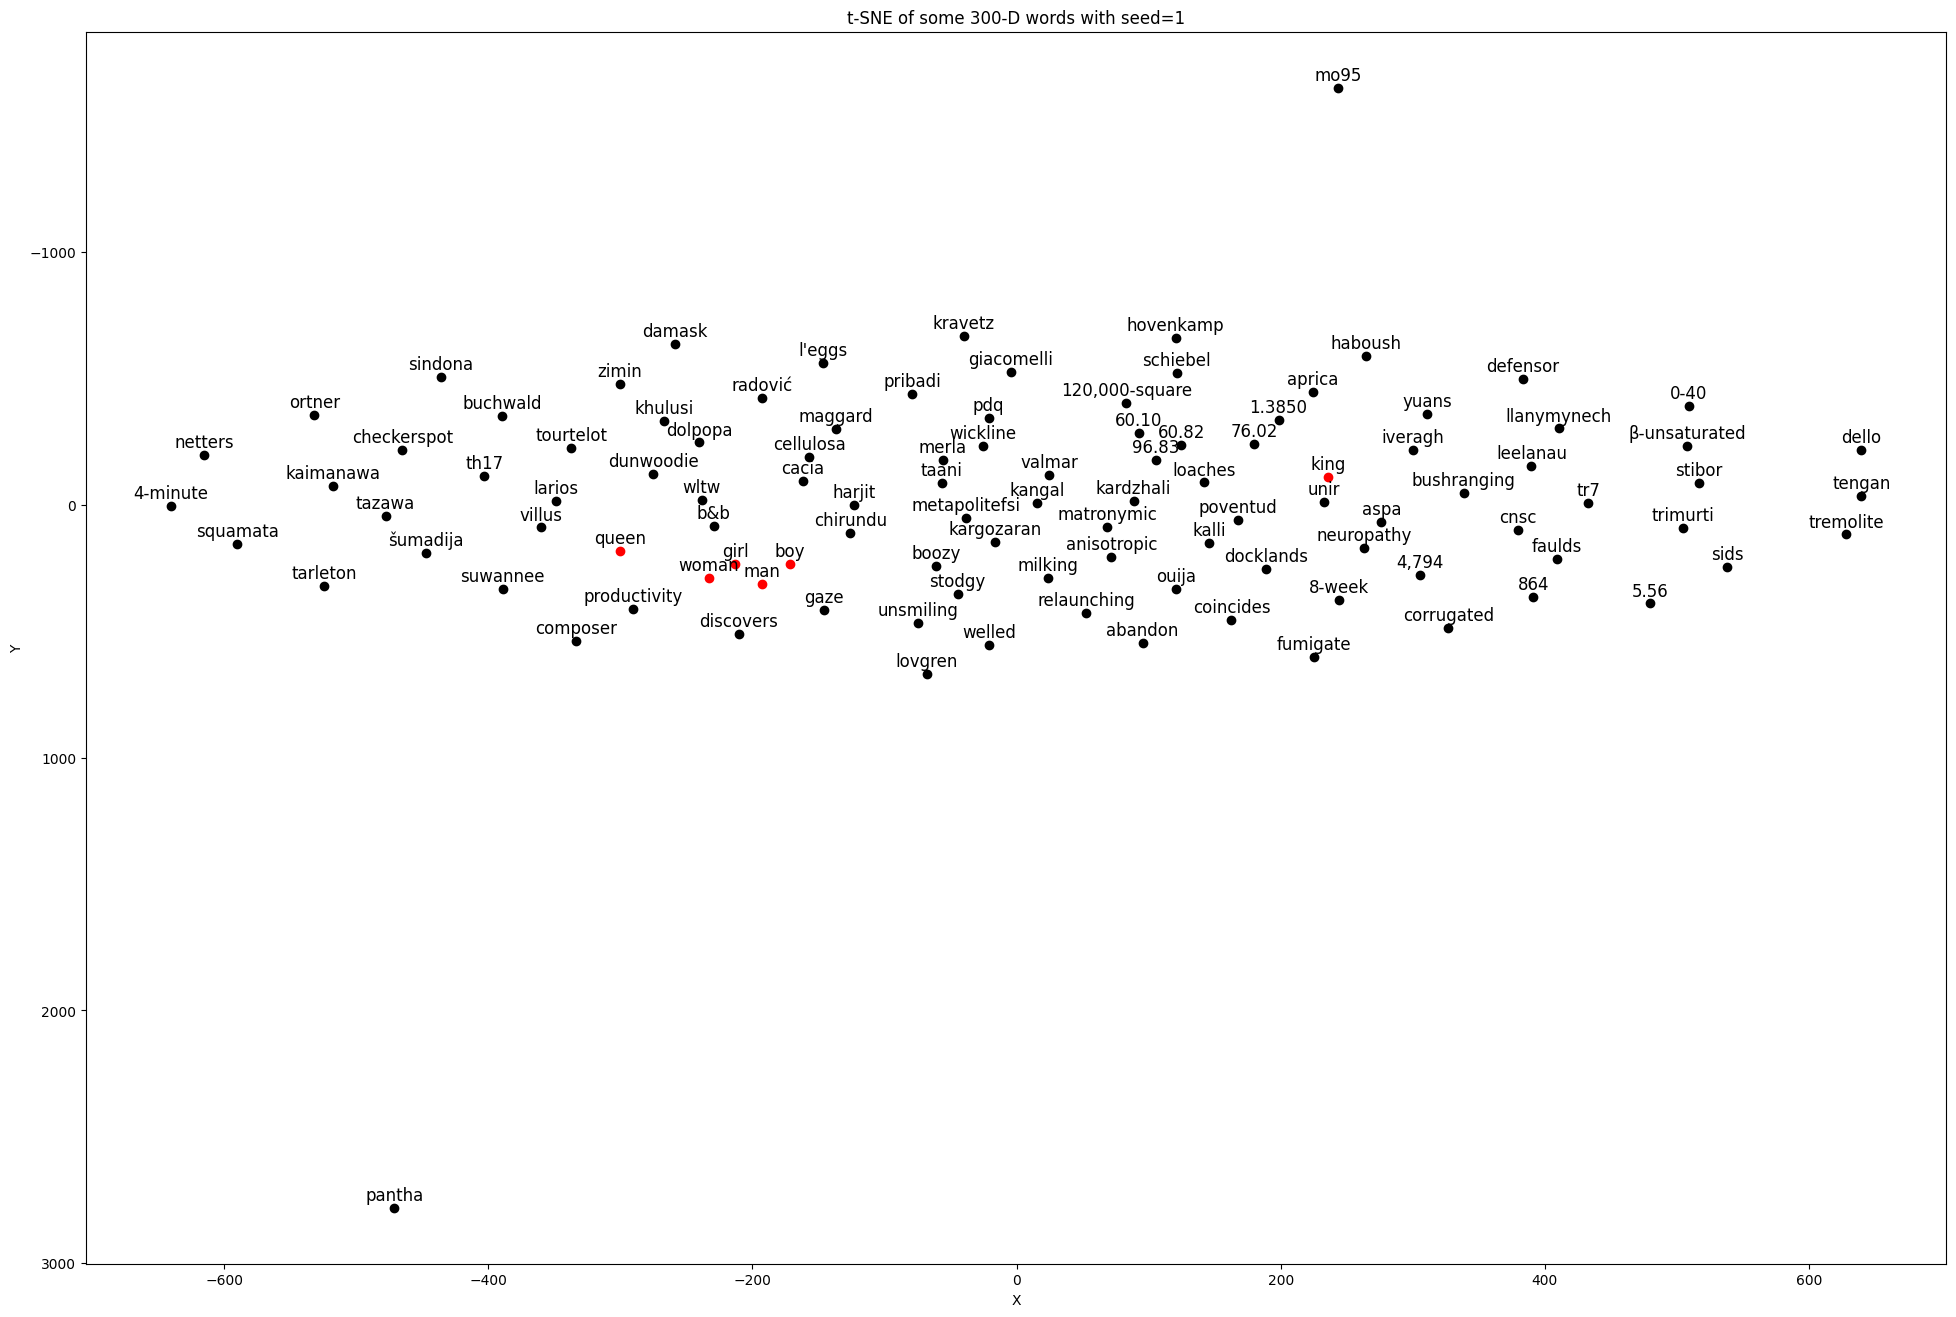

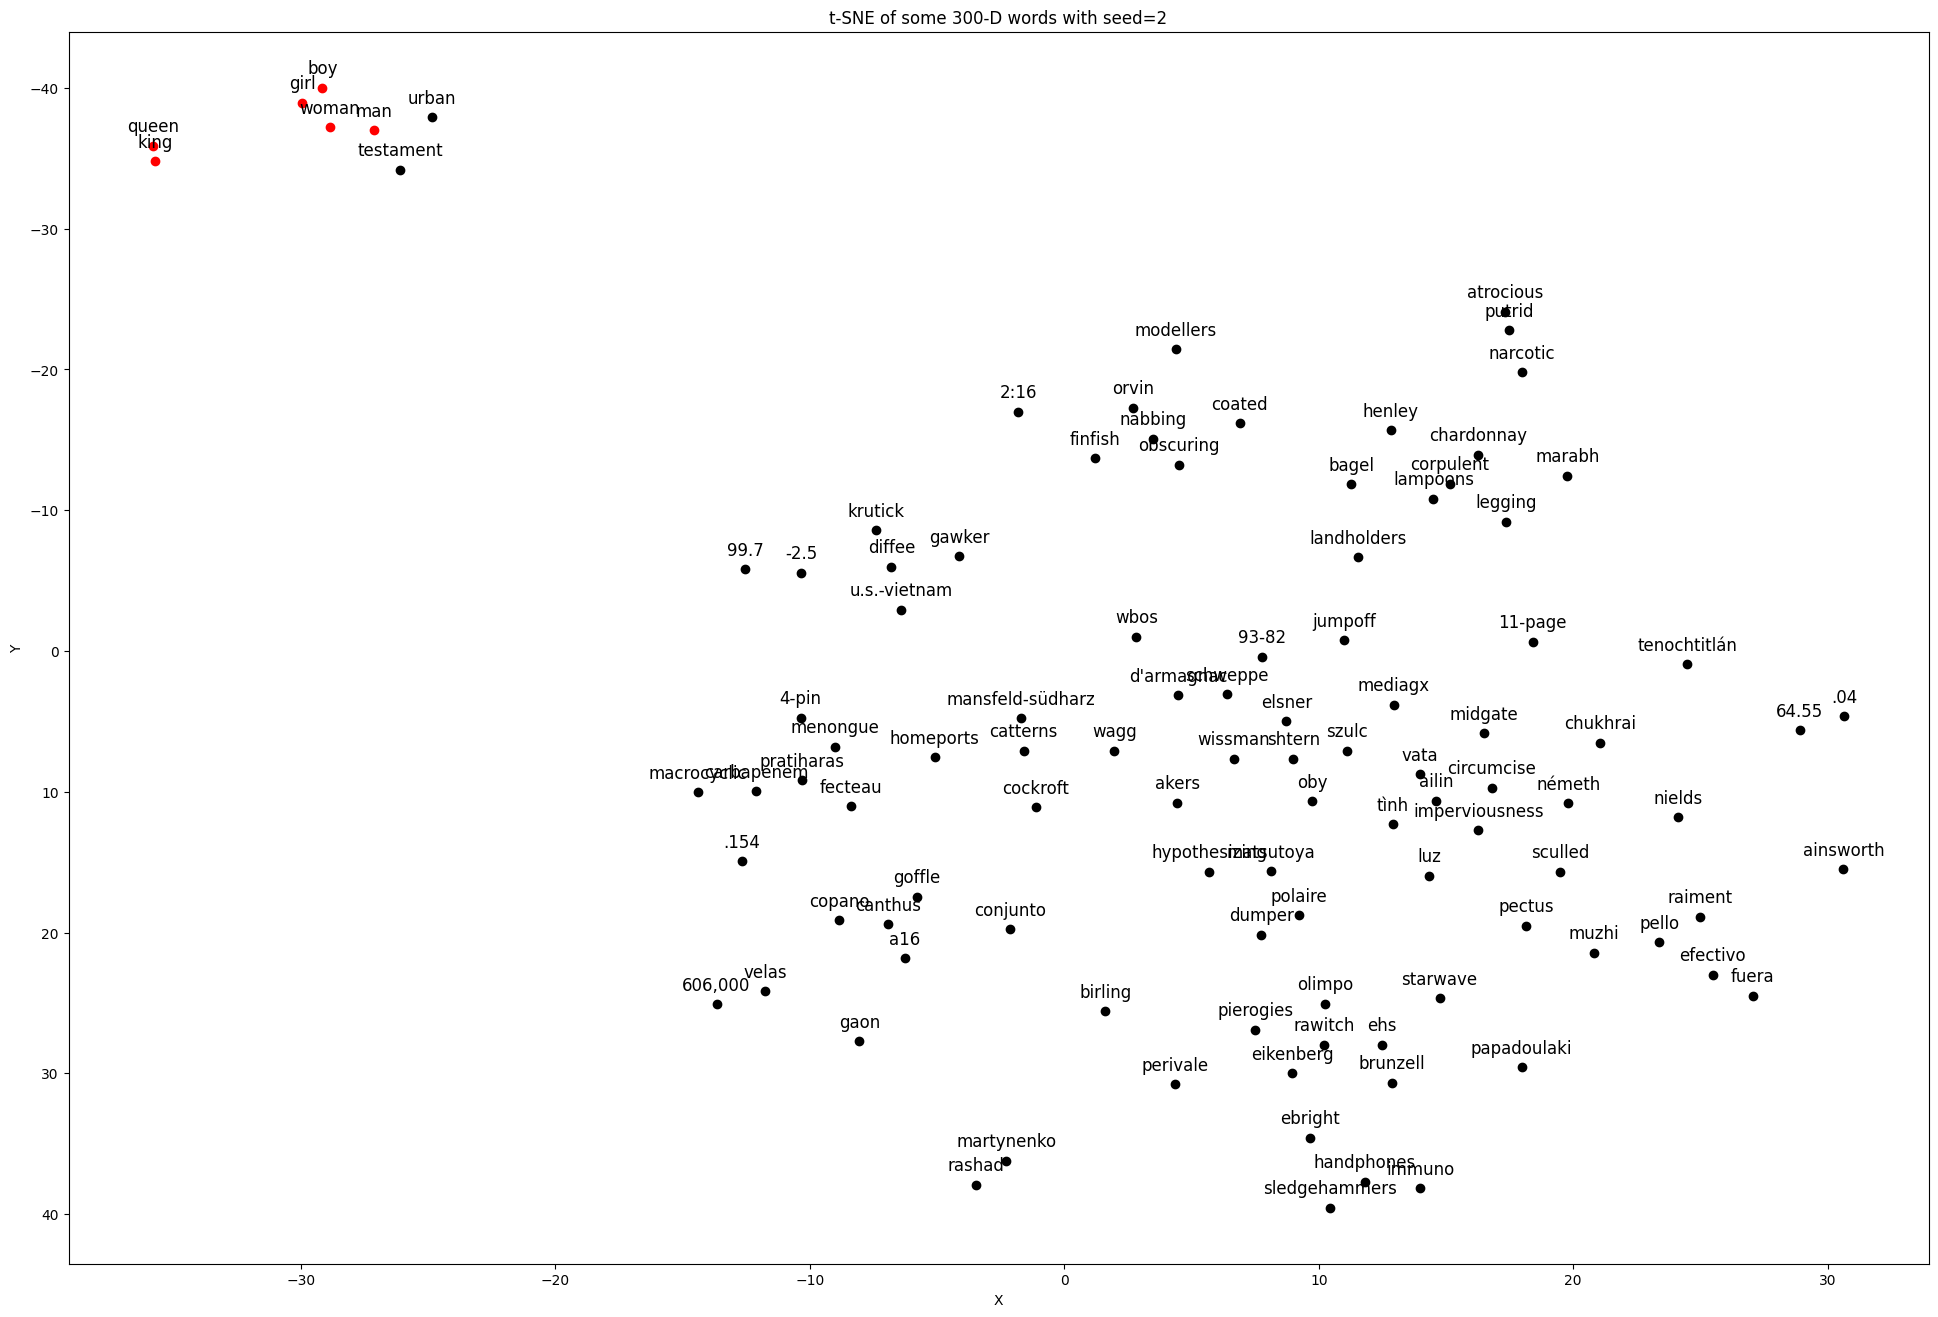

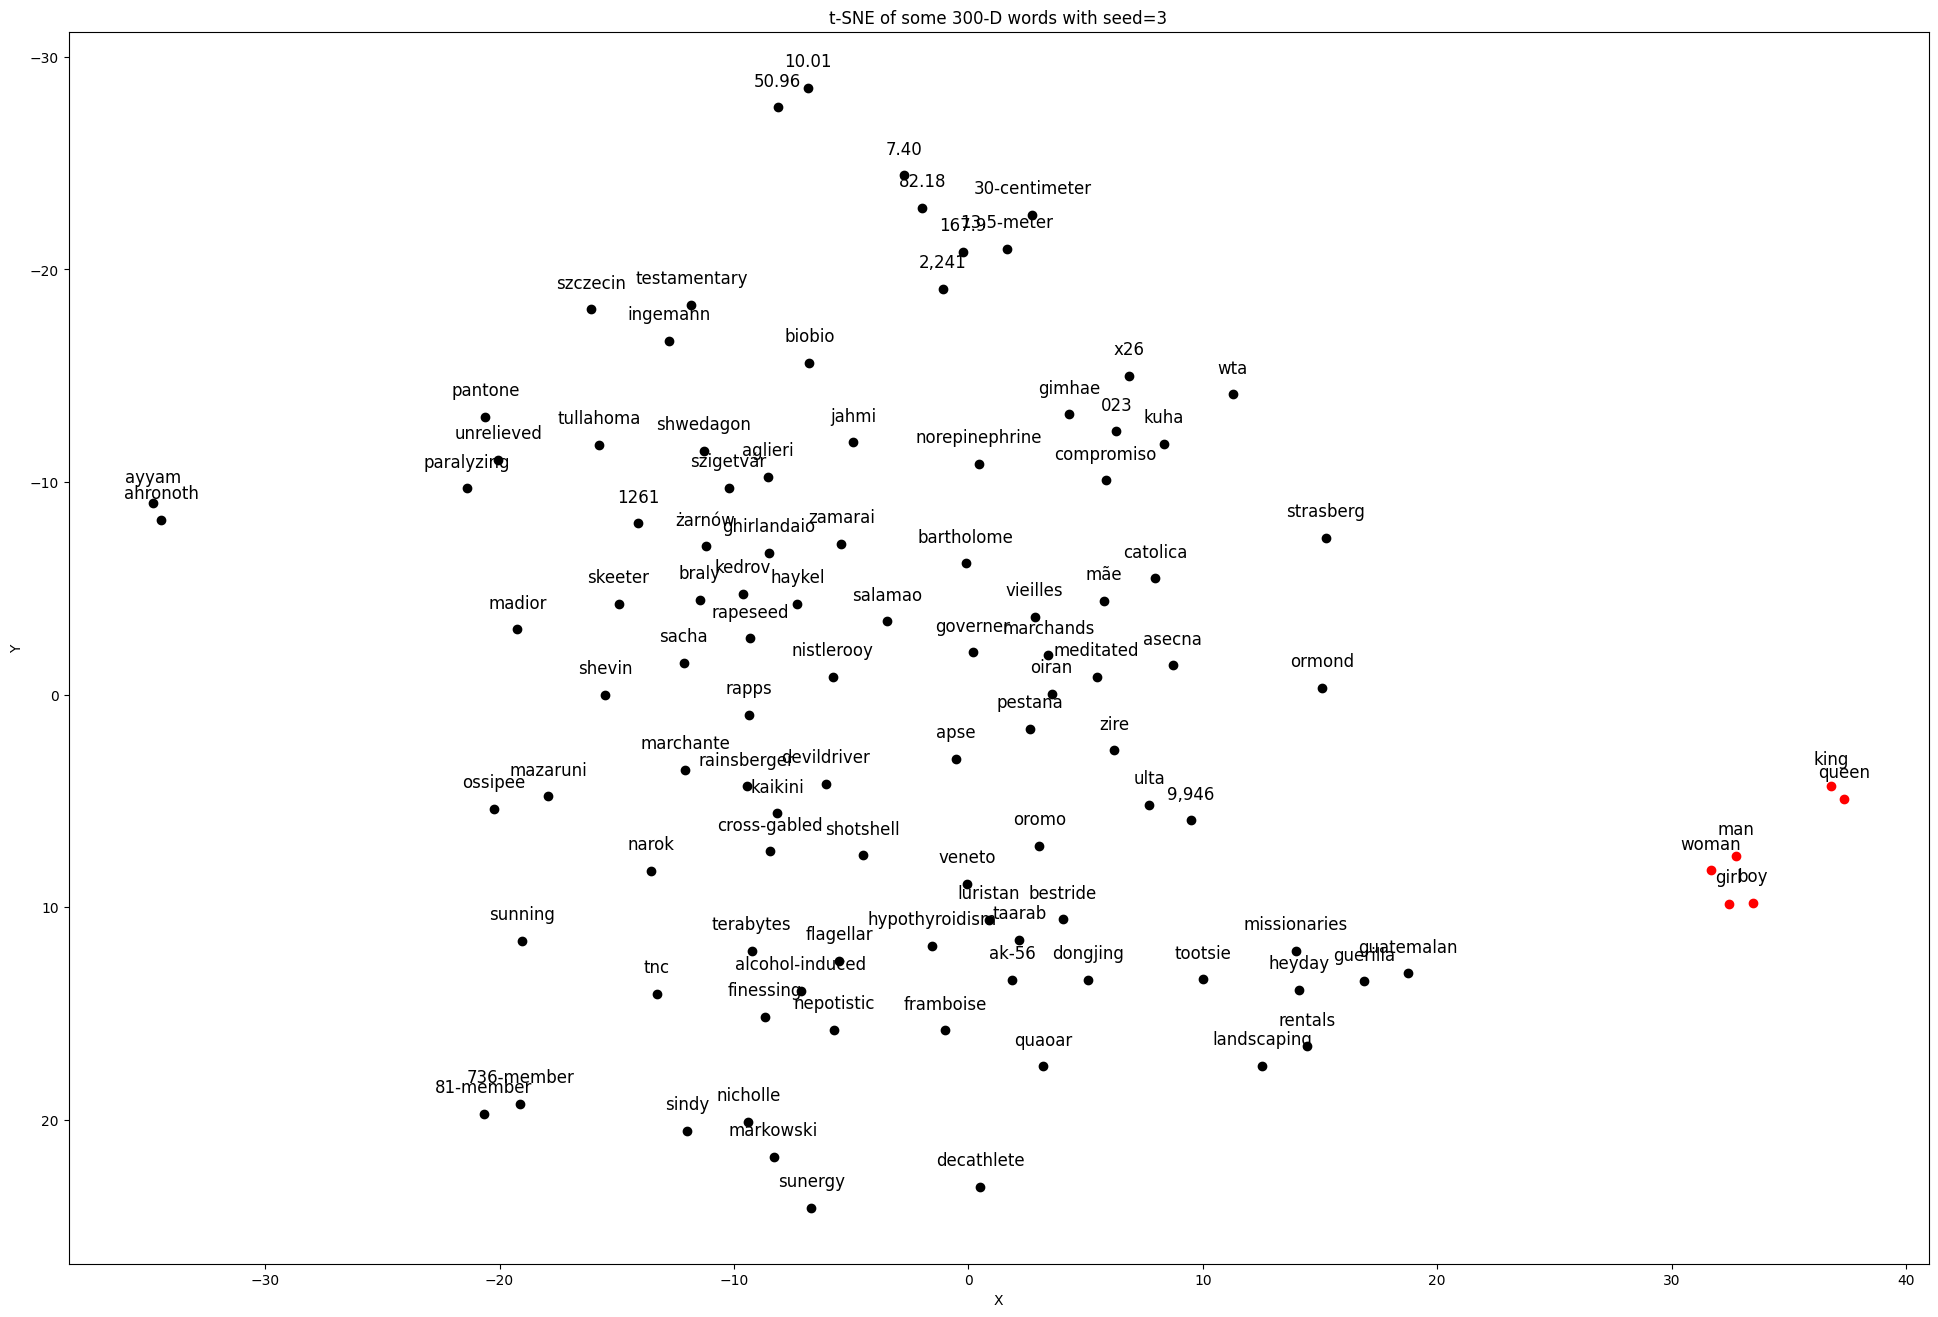

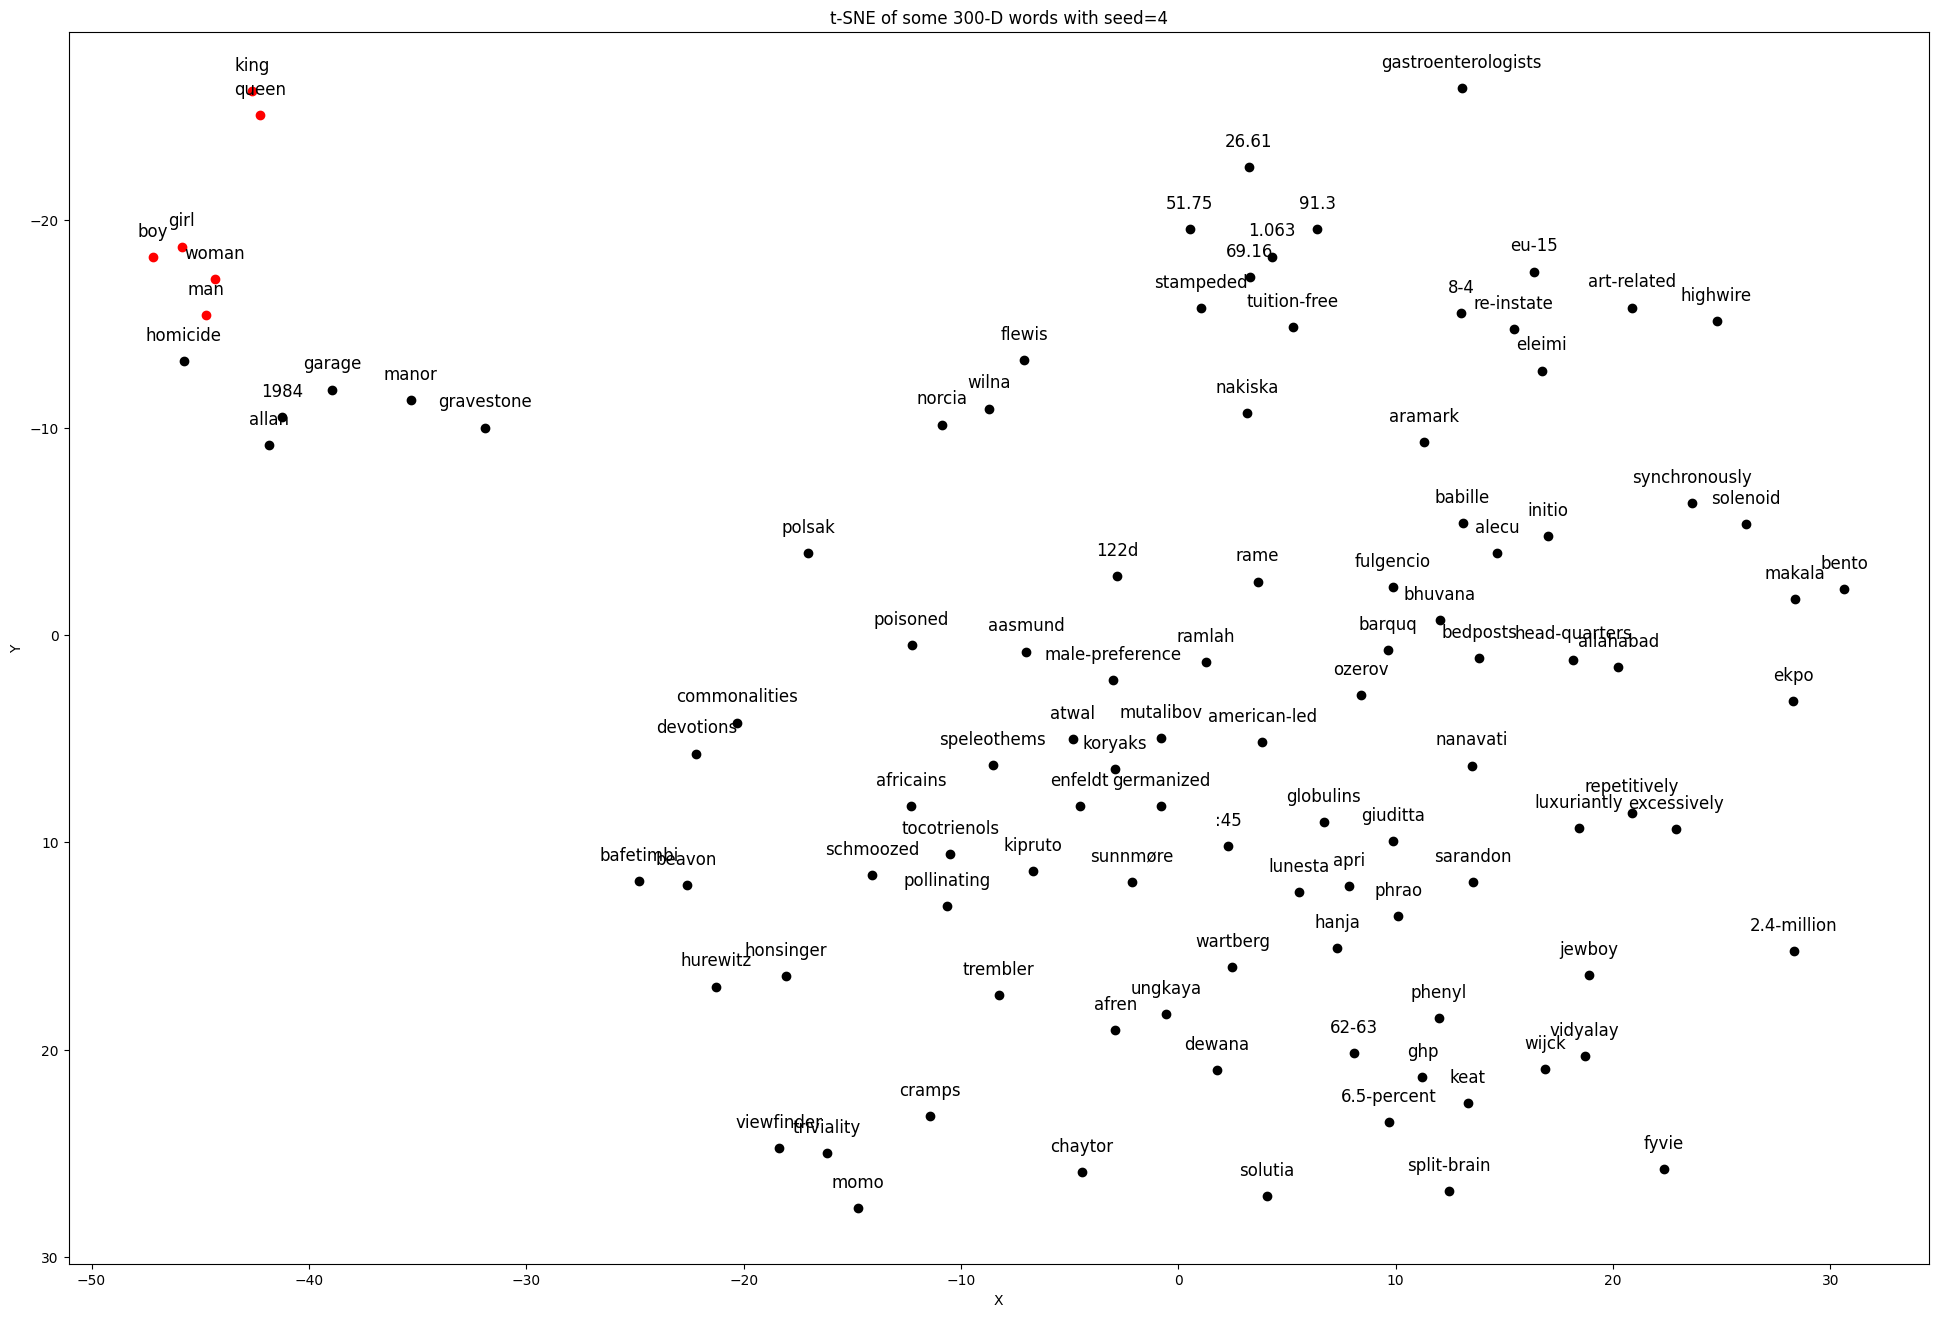

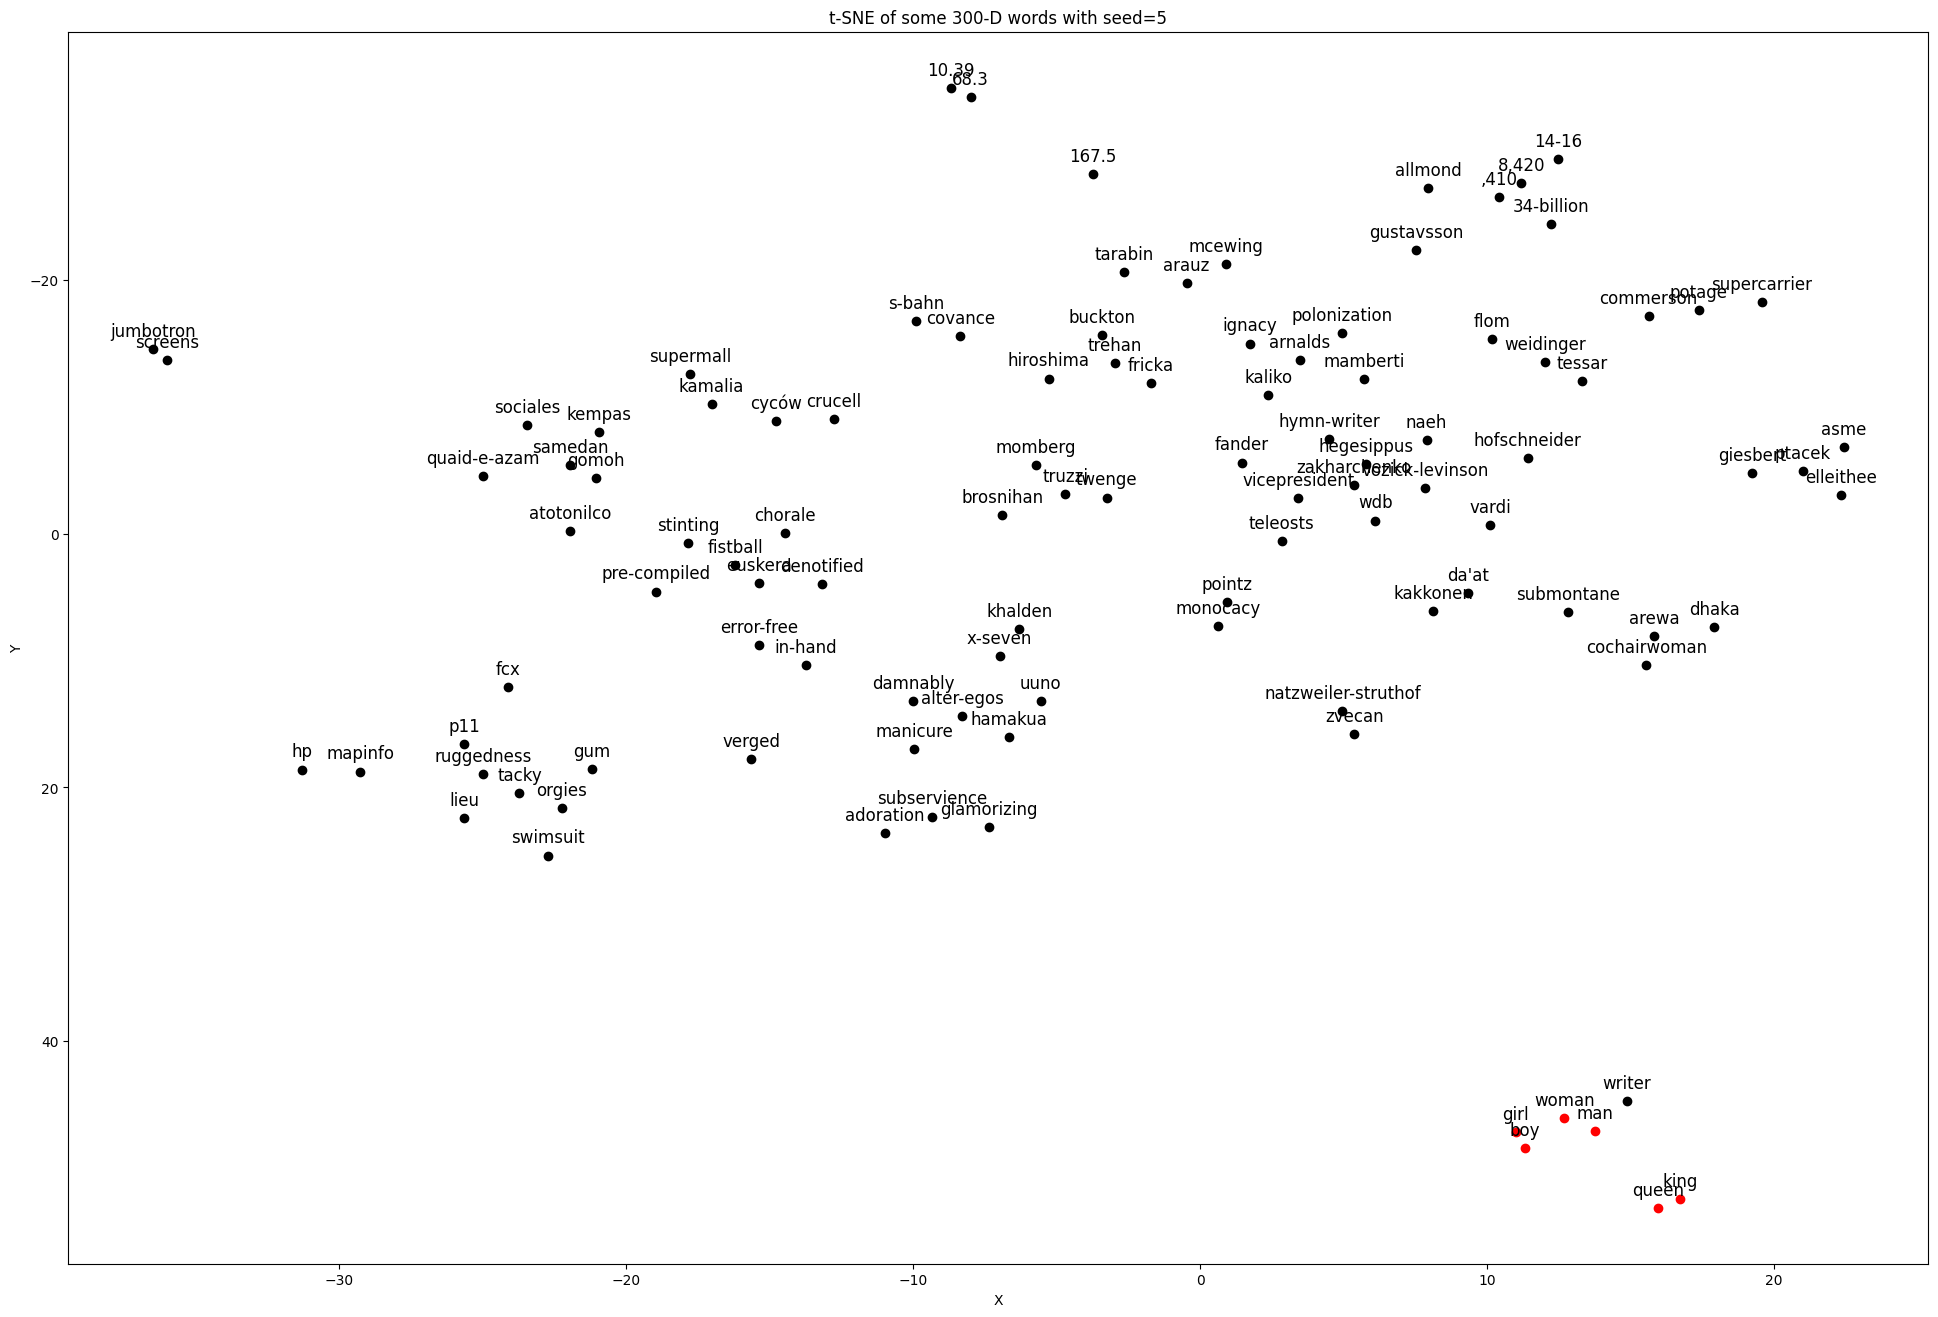

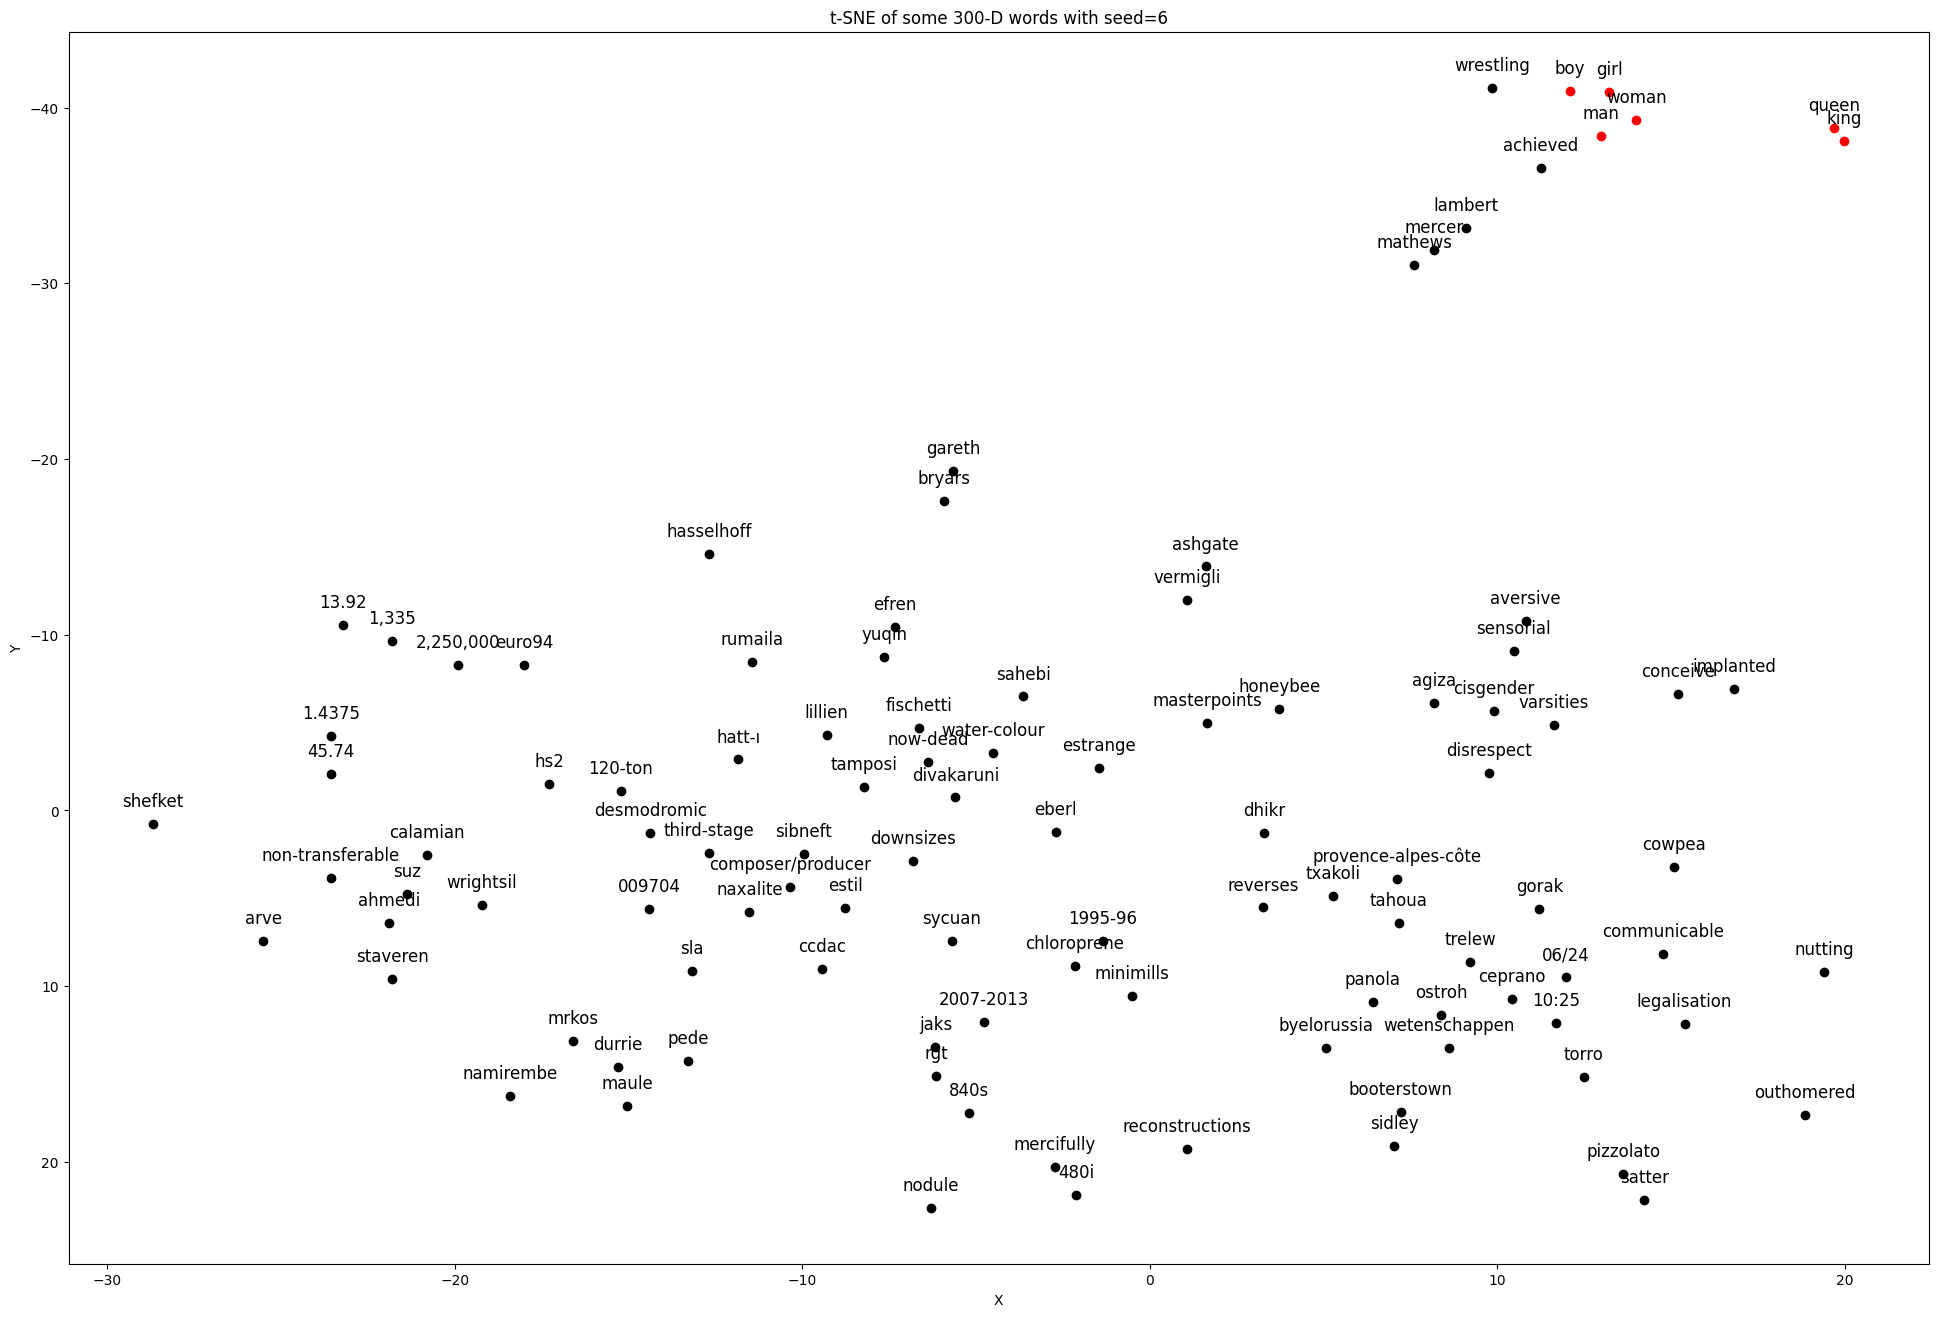

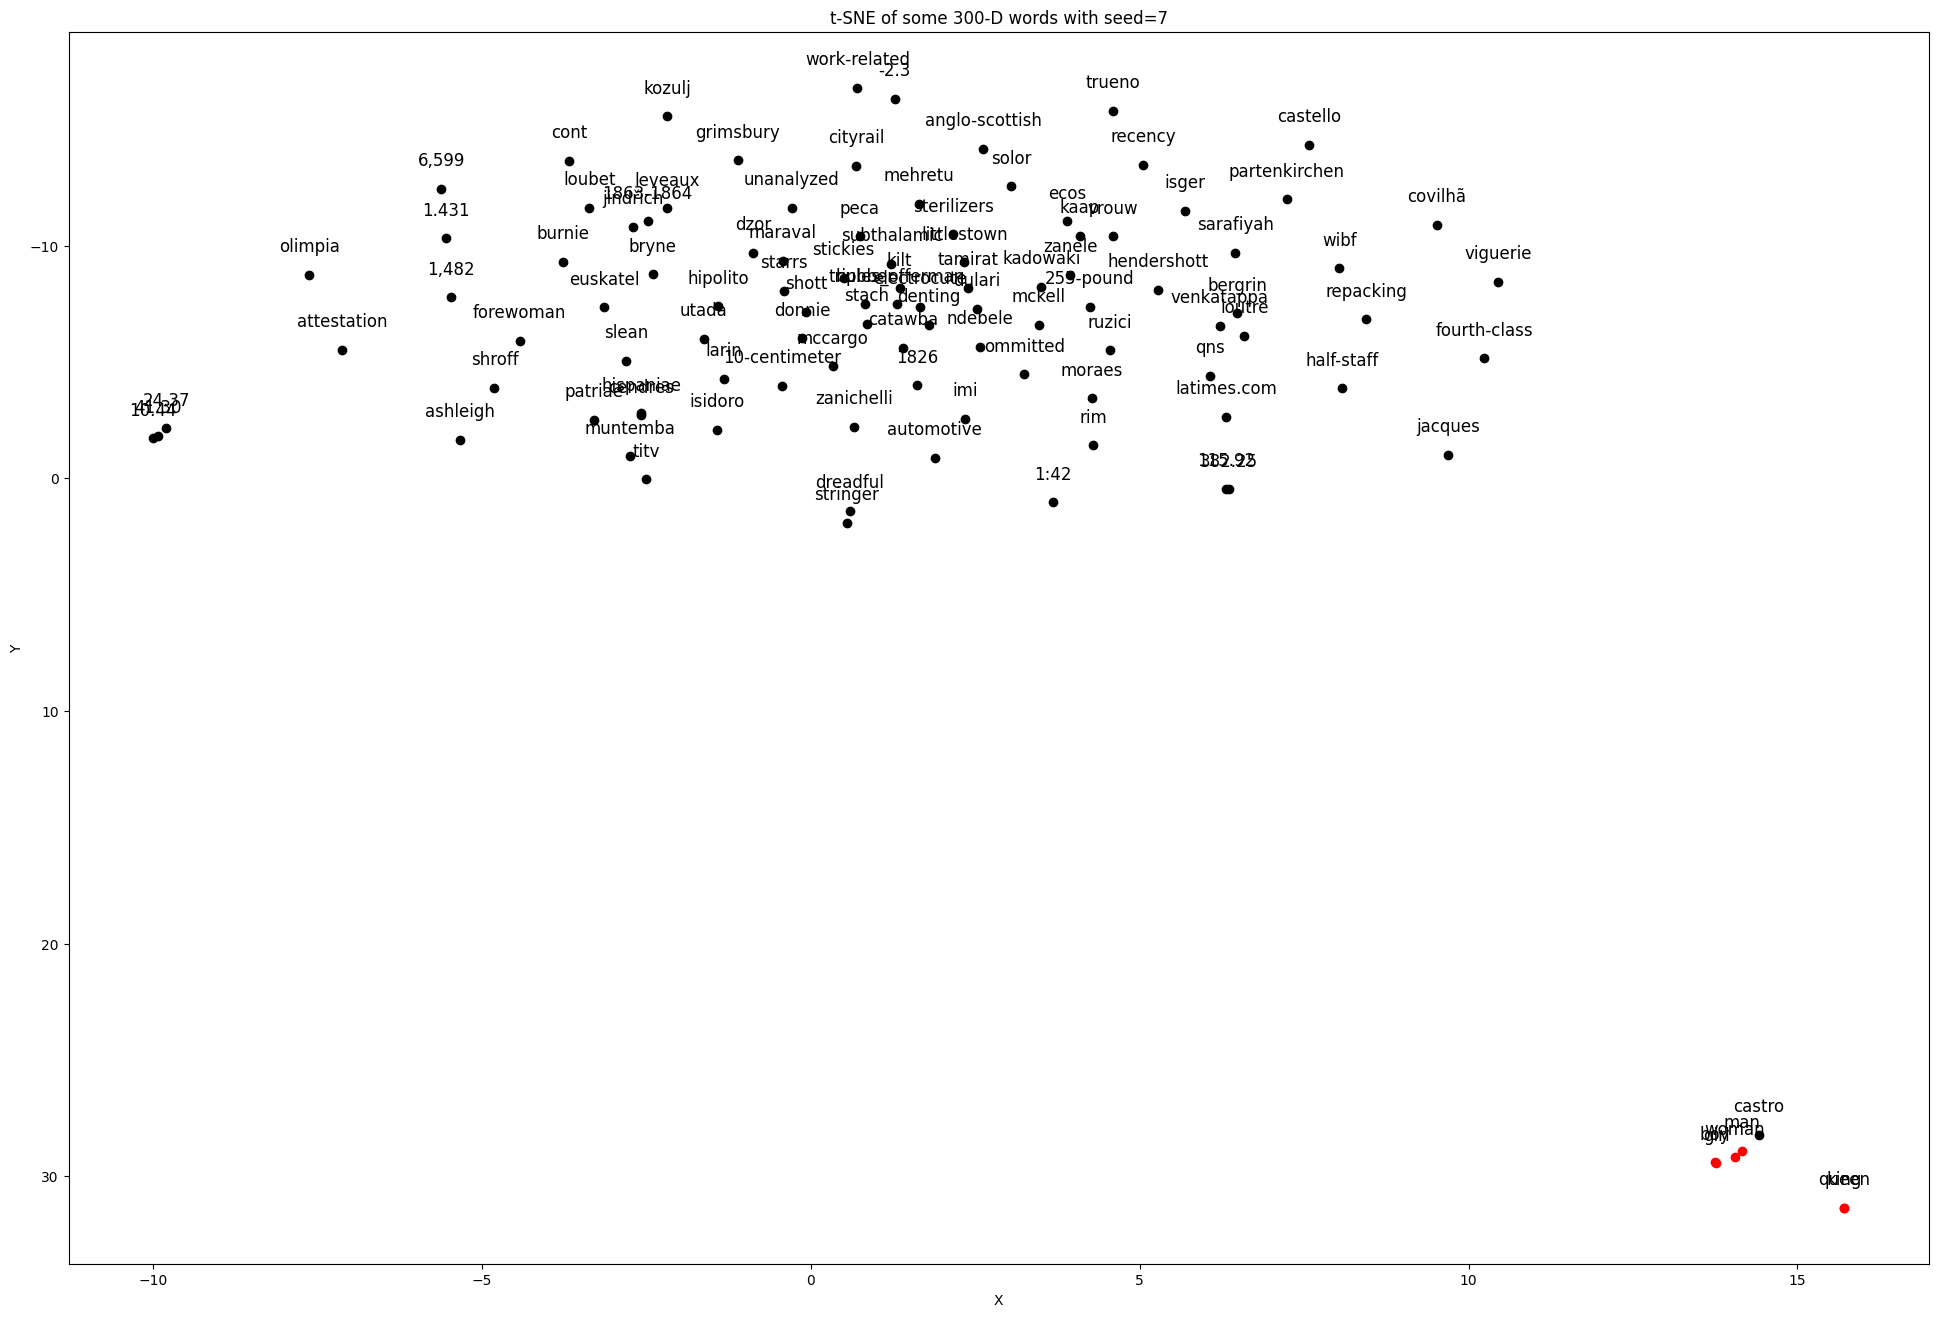

/home/alexey/.conda/envs/thesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/alexey/.conda/envs/thesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/alexey/.conda/envs/thesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


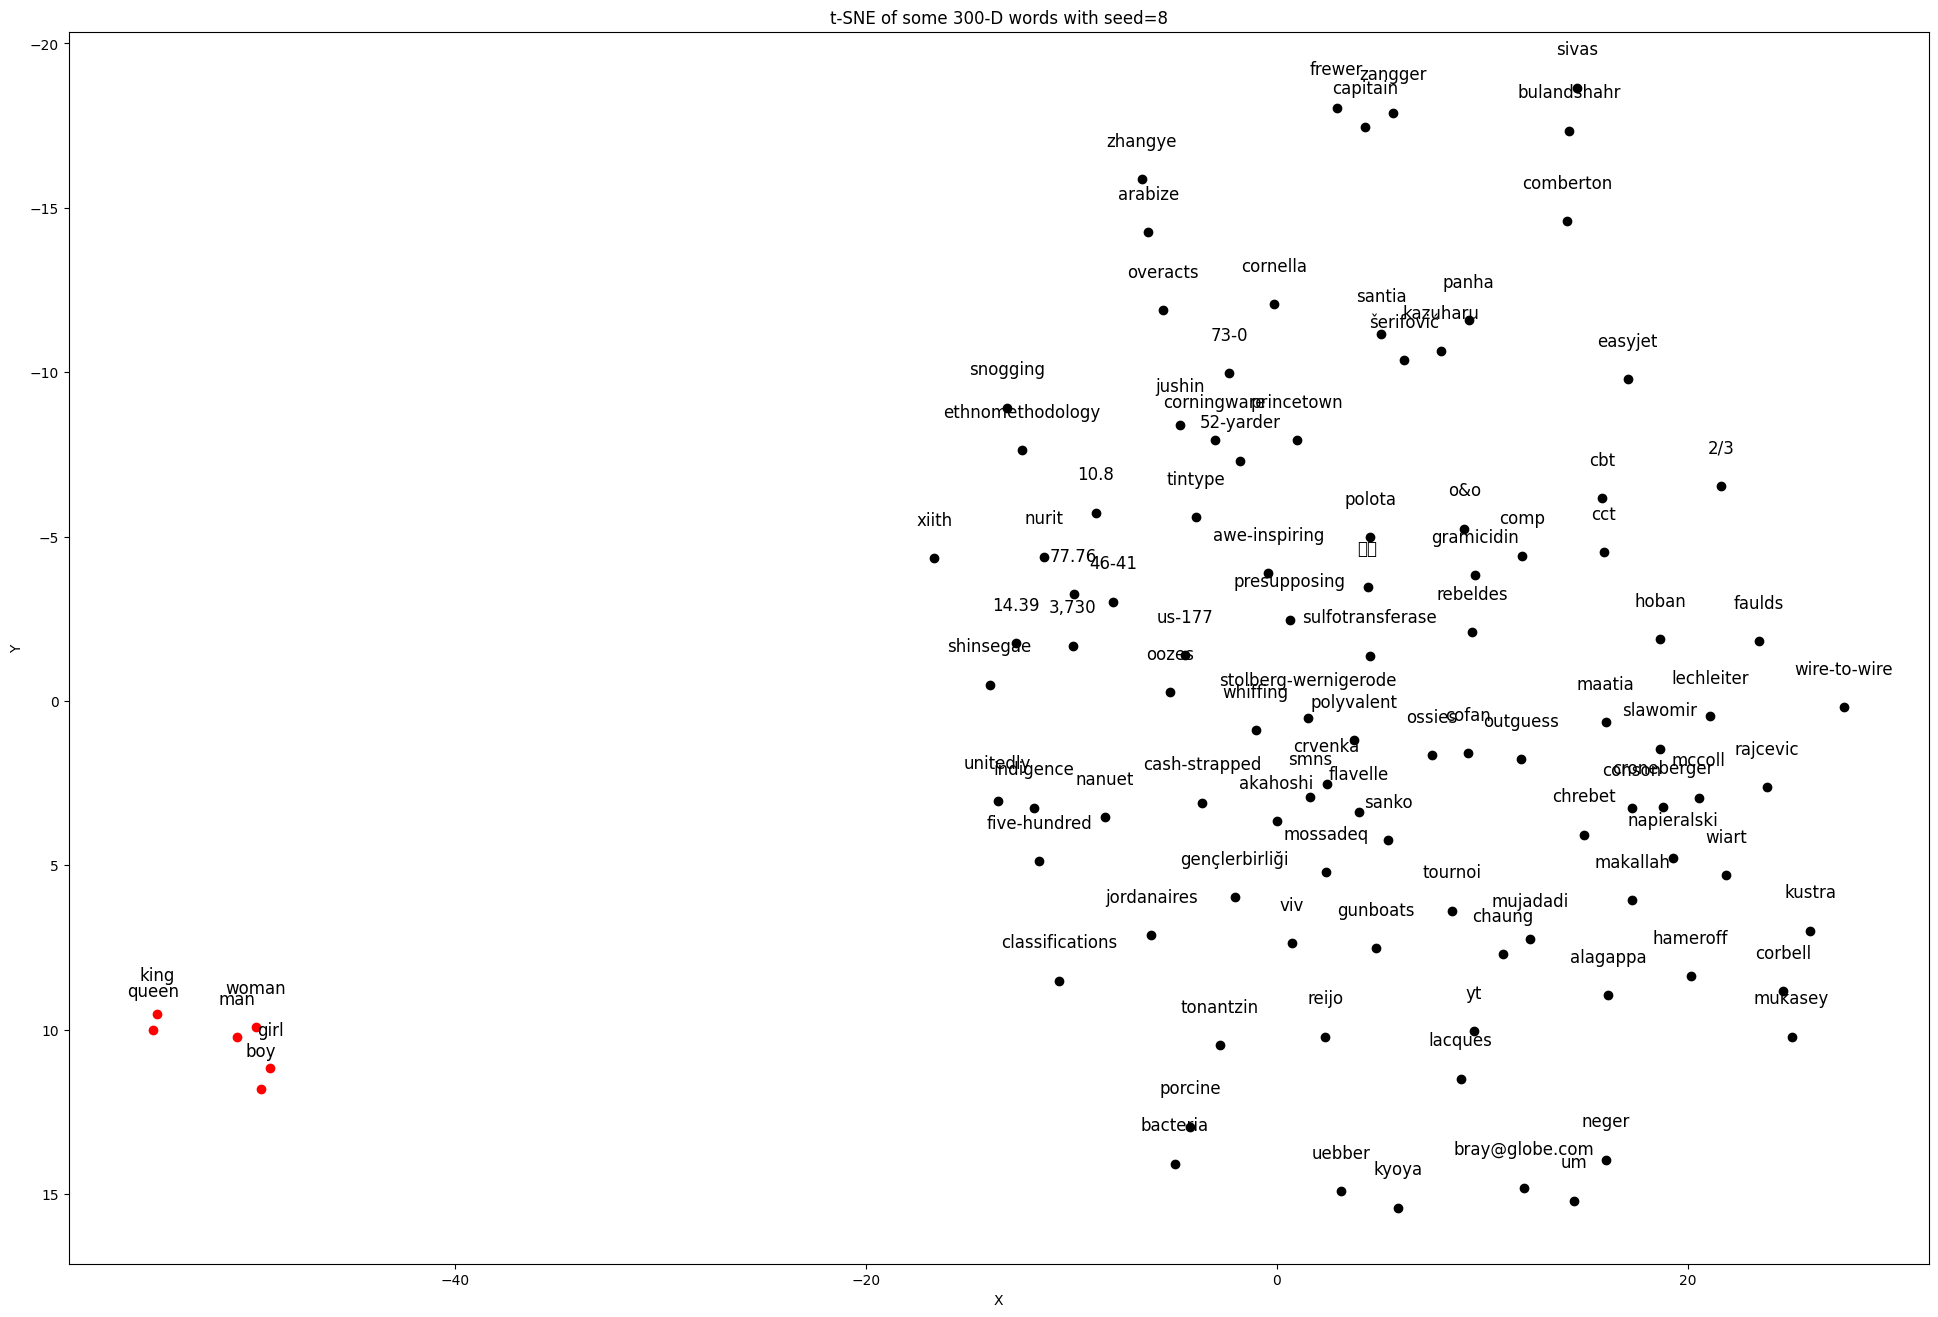

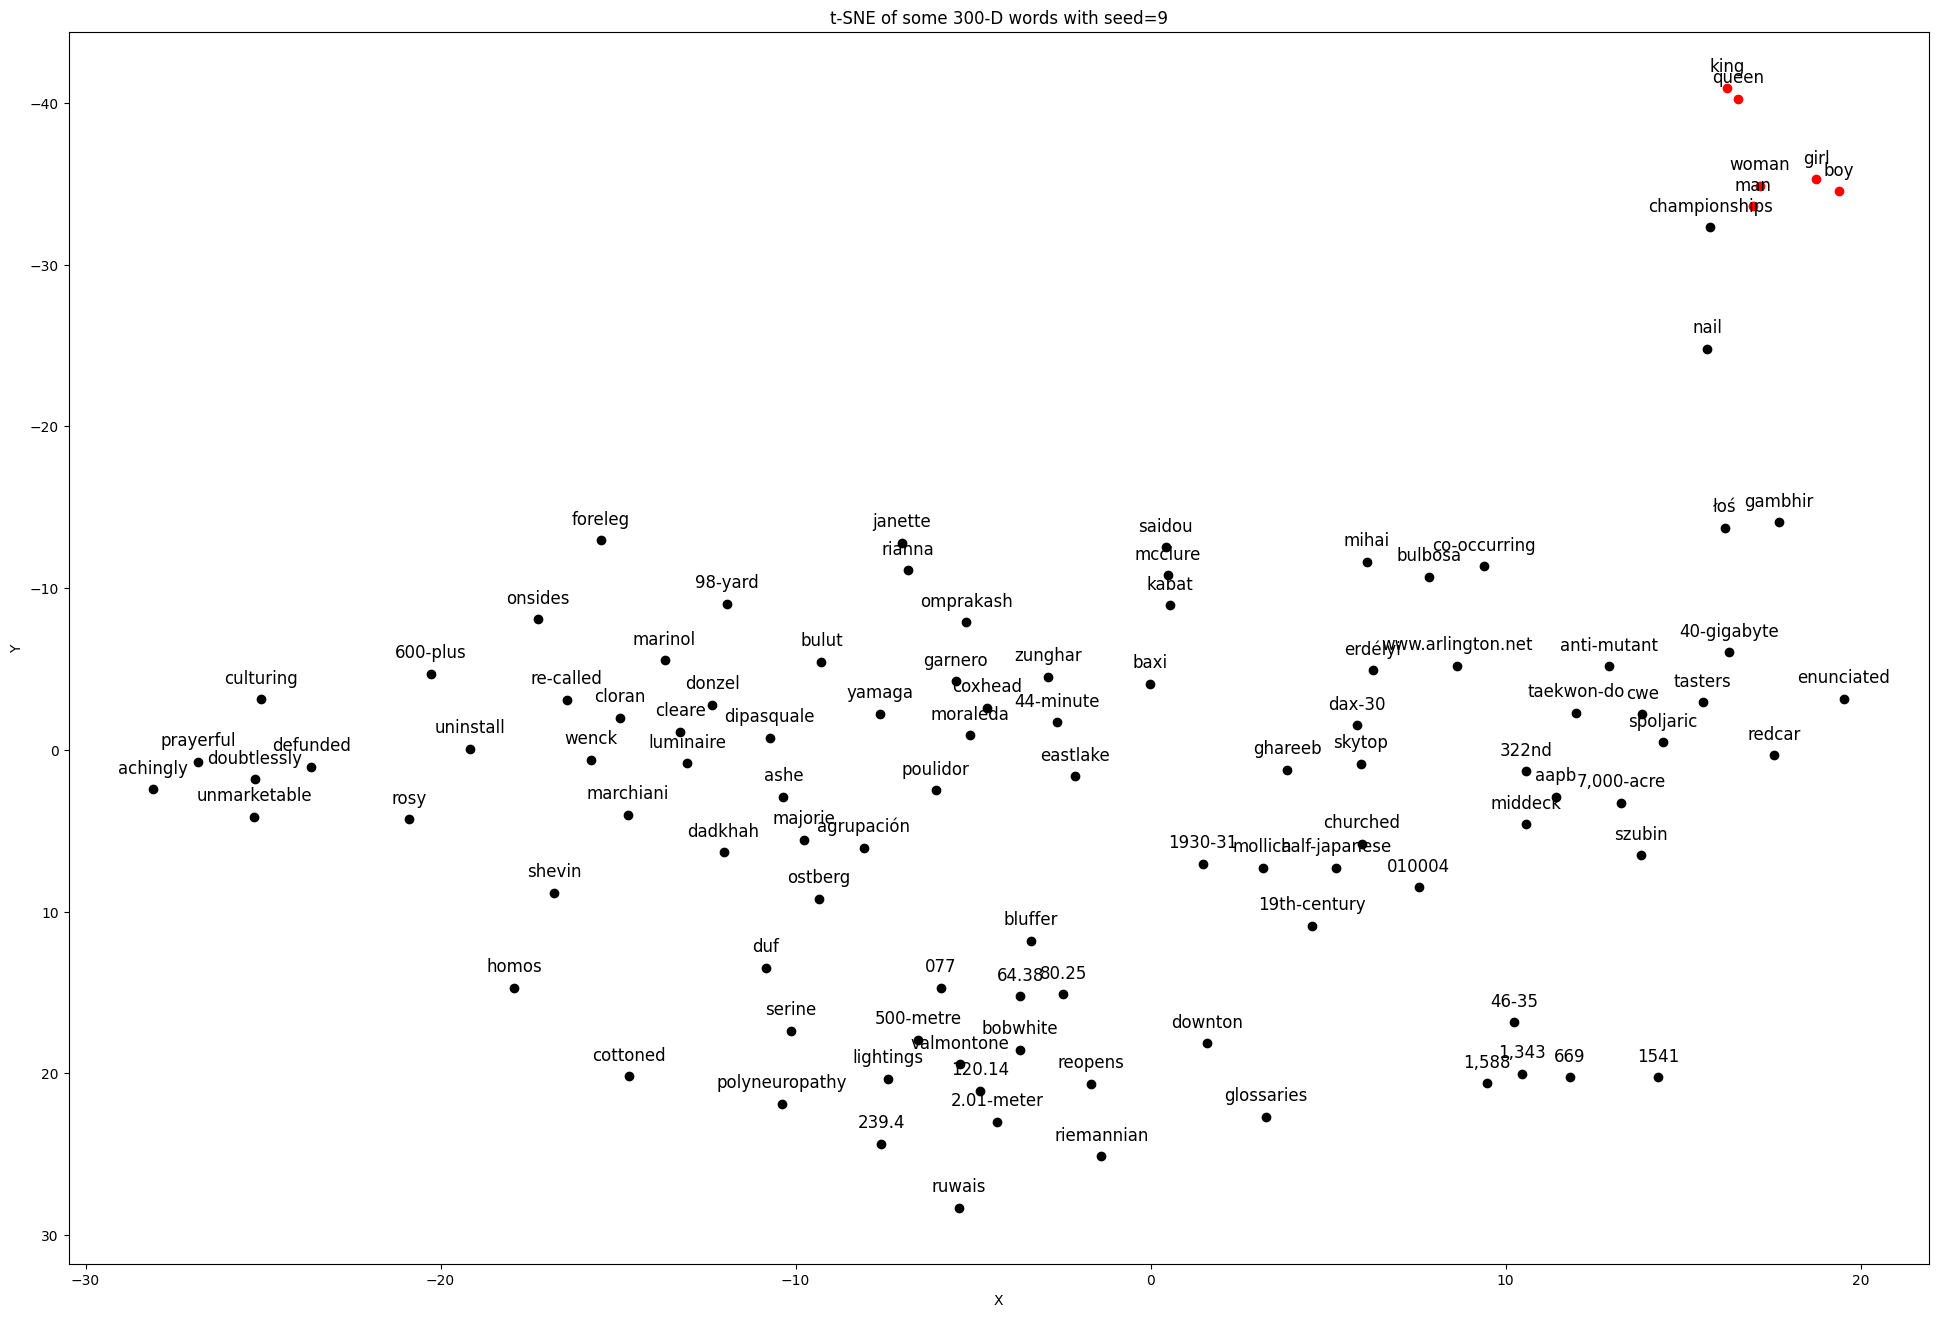

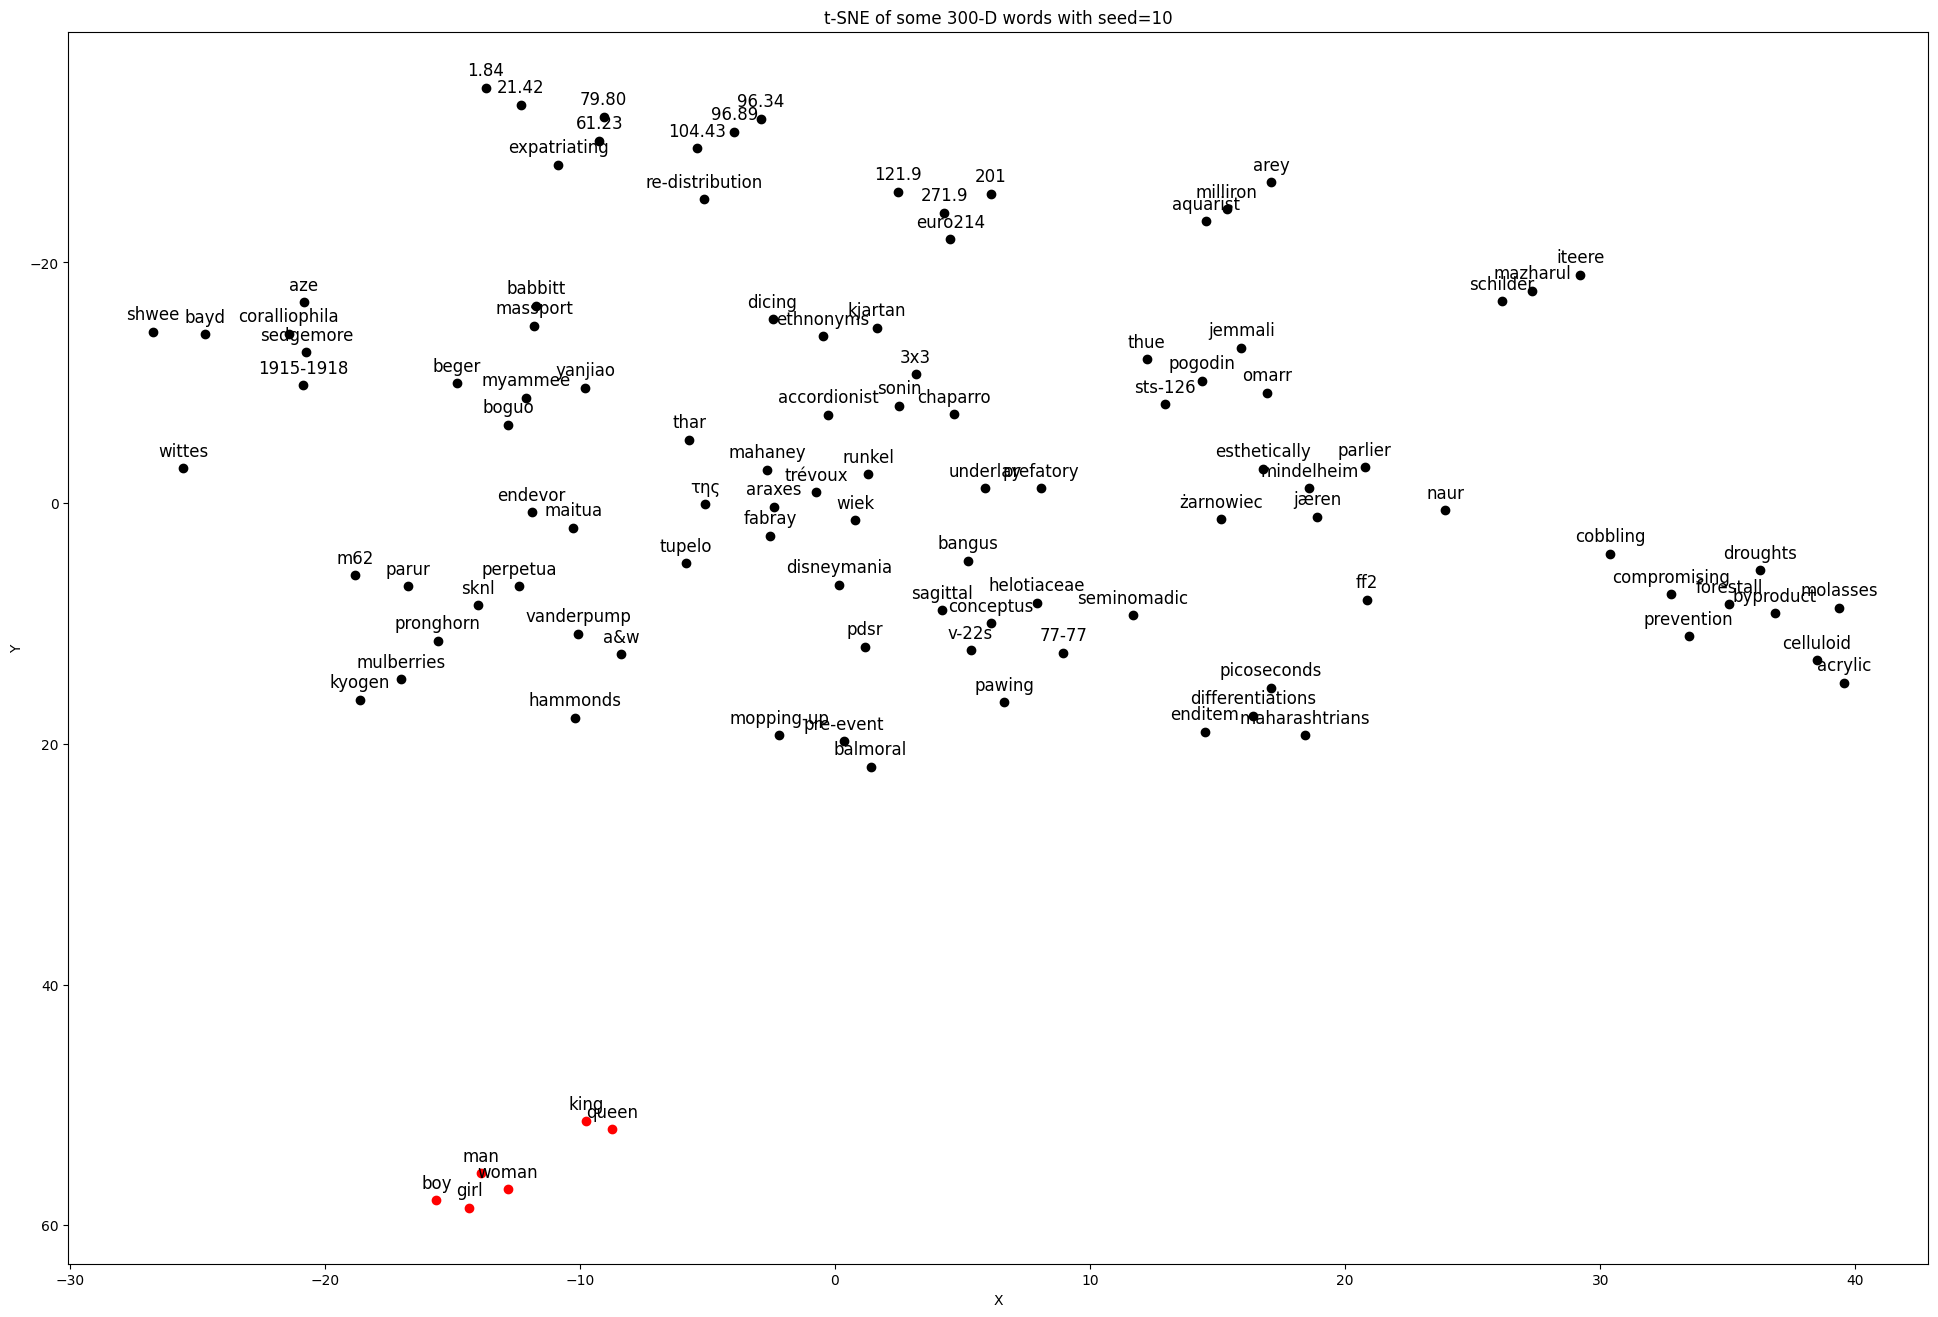

In [17]:
def plot_t_SNE(seed, n_words, fixed_words, label_offset):
    # Fix seed
    np.random.seed(seed)
    
    # Get n_words random indices
    n_words = 100
    idxs = np.random.choice(400000,n_words, replace=False)

    # Store the vectors and words from these random indices
    random_vecs = list()
    random_words = list()

    for idx in idxs:
        random_vecs.append(vecs[idx])
        random_words.append(words[idx])

    # Add constant words
    for wrd in fixed_words:
        random_vecs.append(vecs[words.index(wrd)])
        random_words.append(wrd)

    # Get t-SNE version of these vectors
    X = np.array(random_vecs)
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=3).fit_transform(X)

    # Plot our scatter plot
    plt.figure(figsize=[24,16])
    for i in range(len(X_embedded)):
        vec = X_embedded[i]
        wrd = random_words[i]
        # Colors for random and fixed words
        if i < n_words:
            plt.scatter(vec[0], vec[1], color='black')
        else:
            plt.scatter(vec[0], vec[1], color='red')
        plt.text(vec[0],vec[1]+label_offset,wrd,fontsize=12, ha='center')

    plt.gca().invert_yaxis()
    plt.ylabel("Y")
    plt.xlabel("X")
    plt.title(f"t-SNE of some 300-D words with seed={seed}")
    plt.show()
    plt.close()

for seed, offset in [(1, -30), (2, -1), (3, -1), (4, -1), (5, -1), (6, -1), (7, -1), (8, -1), (9, -1), (10, -1)]:
    plot_t_SNE(seed=seed, n_words=100, fixed_words=["man", "woman", "king", "queen", "girl", "boy"], label_offset=offset)

So, from the above there are a few observations we can make:
- The distribution of the vectors when passed through t-SNE is highly dependent on the numpy seed used. This means that there are some decisions in the t-SNE algorithm that require randomness (and since this is run on a computer, it's really pseudo-random). However, the words "queen", "man", "woman", "boy", and "girl" were always grouped together in the above examples, with the seed=1 case having "king" completely separated (otherwise "king" was always in the group as well).
- The "words" that were really numbers were often grouped together as well, this is best seen in seeds 3 and 10. However, in both of these seeds we can see numbers which were separated from the main grouping.  We can once again appeal to the meaning of these numbers being the reason they are separate. For example, in seed=3 it's likely that "1261" is a date. However, that wouldn't explain why "9,946" is also separate from the grouping which includes "2,241".
- Sometimes, the direction that we would expect the vectors to be distributed are different. The seed=10 case is a good example of what we would expect with the "man", "woman", "king", and "queen" case, where the vector equation "man-woman+king" would be near "queen". However, this wouldn't work in the seed=1 case, since "king" is so far off in the distance from "queen".

This analysis then leads to the obvious conclusion that t-SNE is useful in analyzing data and getting vague ideas about how the various high-dimensional vectors are related to one-another. t-SNE shouldn't be used as a conclusive form of drawing relationships between vectors, since there is inherent data loss when moving from 300 dimensions down to 2 dimensions.

### **Conclusions**

Overall, I think this report went really well. I became very comfortable with dealing with vector representation of words by utilizing both cosine similarity and t-SNE. I also became more familiar with the specific kinds of words used in the GloVe vocabulary. I would like to explore the implementation of GloVe, but the source code is in C. I think that as we learn about more models in class, I would rather explore an NLP model implemented in PyTorch so that it would be easier to digest.

Thanks for reading!